In [143]:
import pandas as pd # dataframes and csv
import numpy as np # linear algebra
import sklearn as sk # data maniputation
import matplotlib.pyplot as plt # data visualization
import re # regular expressions for the text
import tensorflow as tf # for ML


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



                                                  text sentiment
0    Hi Leah, I ordered this early to give to a co-...  Positive
1    Good evening, \n  I just received my order! I ...  Positive
2    I couldn’t find where I could write a review b...  Positive
3    I received my order today and gave it to my si...  Positive
4    ﻿Max,\n\nWe received the heart but sadly are d...  Negative
..                                                 ...       ...
249    Thank you, this is beautiful and they loved it.  Positive
250                    Thanks so much. They lookgreat!  Positive
251  Emily, \n  THANK YOU so much for the new “bric...  Positive
252  Jacqueline,  \n  I just received the replaceme...  Positive
253  Order #(857)982-509708\nI just received my ord...  Positive

[254 rows x 2 columns]


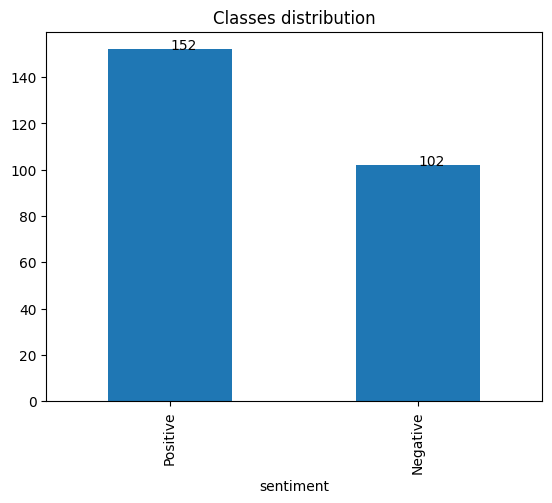

In [144]:
labels = pd.read_csv("./data/labels.csv")
reviews = pd.read_csv("./data/reviews.csv")

reviews = reviews.merge(labels,"outer","id")
dataset = reviews.drop(labels = "id",axis=1)
print(dataset)

dataset["sentiment"].value_counts().plot(kind='bar', title='Classes distribution')
count_positive = len([i for i in dataset["sentiment"] if i=="Positive"])
count_negative = len([i for i in dataset["sentiment"] if i=="Negative"])
plt.text(0,count_positive,str(count_positive))
plt.text(1,count_negative,str(count_negative))
plt.show()


Negative to Positive ratio is okay. No need to fix training and testing datasets manualy

In [155]:
#Finding the vocab size
words = []
delimiters = [",", ")", "("]

for i in dataset["text"]:
    i = re.split(', | ', i)
    for j in i:

        words.append(j)
words = list(set(words))
print(len(words))
print("AVG LENGTH: " + str(np.array([len(i) for i in dataset["text"]]).mean()))

2970
AVG LENGTH: 303.0


In [157]:
train, test = train_test_split(dataset, test_size=0.3, random_state=42, shuffle=True)

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for t in train["text"]:
  training_sentences.append(t)

for s in train["sentiment"]:
  if s == "Positive": # Redo the labels so the processing is faster 
    training_labels.append(1)
  else:
    training_labels.append(0)

# Loop over all test examples and save the sentences and labels
for t in test["text"]:
  testing_sentences.append(t)

for s in test["sentiment"]:
  if s == "Positive": # Redo the labels so the processing is faster 
    testing_labels.append(1)
  else:
    testing_labels.append(0)

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)



In [162]:
# Parameters
vocab_size = 750
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences)

In [163]:
# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [164]:
# Parameters
embedding_dim = 8
lstm_dim = 16
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.008)

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 8)           6000      
                                                                 
 bidirectional_9 (Bidirecti  (None, 32)                3200      
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 6)                 198       
                                                                 
 dense_19 (Dense)            (None, 1)                 7         
                                                                 
Total params: 9405 (36.74 KB)
Trainable params: 9405 (36.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [165]:
NUM_EPOCHS = 15
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/15
2/2 [==============================] - 4s 879ms/step - loss: 0.6911 - accuracy: 0.5706 - val_loss: 0.6643 - val_accuracy: 0.6623
Epoch 2/15
2/2 [==============================] - 0s 141ms/step - loss: 0.6812 - accuracy: 0.5706 - val_loss: 0.6406 - val_accuracy: 0.6623
Epoch 3/15
2/2 [==============================] - 0s 139ms/step - loss: 0.6761 - accuracy: 0.5706 - val_loss: 0.6384 - val_accuracy: 0.6623
Epoch 4/15
2/2 [==============================] - 0s 136ms/step - loss: 0.6608 - accuracy: 0.5706 - val_loss: 0.6267 - val_accuracy: 0.6623
Epoch 5/15
2/2 [==============================] - 0s 133ms/step - loss: 0.6292 - accuracy: 0.5706 - val_loss: 0.5486 - val_accuracy: 0.6623
Epoch 6/15
2/2 [==============================] - 0s 132ms/step - loss: 0.5986 - accuracy: 0.5706 - val_loss: 0.5081 - val_accuracy: 0.6623
Epoch 7/15
2/2 [==============================] - 0s 133ms/step - loss: 0.5192 - accuracy: 0.5706 - val_loss: 0.5779 - val_accuracy: 0.6623
Epoch 8/15
2/2 [====

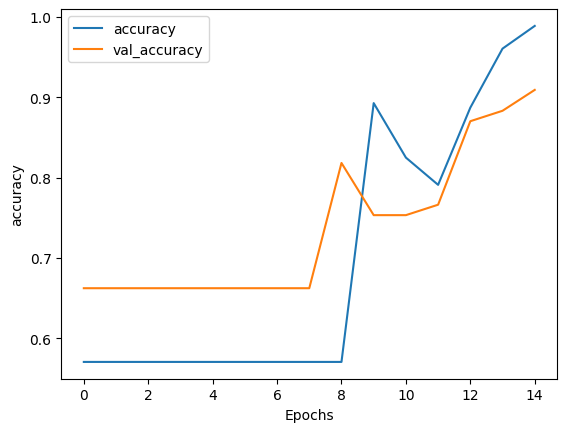

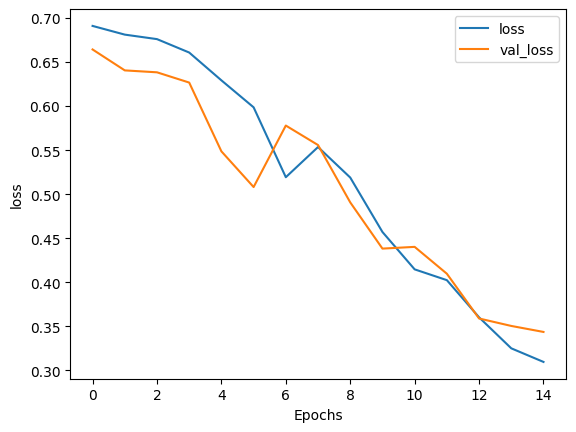

In [166]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')